# **OCR Detection**

In [617]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image,ImageEnhance

## Segmenting into numbers and symbols:

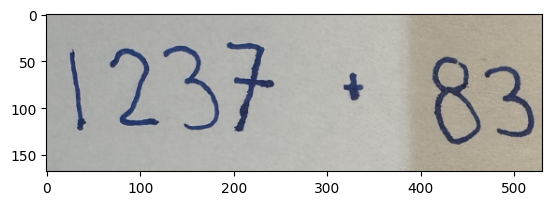

In [640]:
def format(img):
  #resizing so width = 1000, while maintaining aspect ratio
  h, w, c = img.shape
  if (w>1000):
    aspect_ratio = w/h
    w = 1000
    h = int(w/aspect_ratio)
    img = cv2.resize(img, (w, h), interpolation = cv2.INTER_AREA)

  plt.imshow(img) # show image
  plt.show()
  return img

img = cv2.imread('work.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # converting image colours open cv format (RGB)
img = format(img)

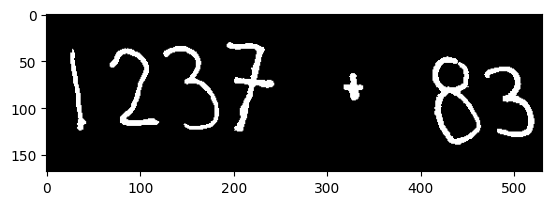

In [641]:
def thresholding(img):
  grey_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  # contrast: pixel intensity > 80 threshold = 255 (max value)
  # inverting: THRESH_BINARY_INV = max values --> 0, all other values --> 255
  ret, thresh = cv2.threshold(grey_img,130,255,cv2.THRESH_BINARY_INV) #high contrast, then inverting image
  plt.imshow(thresh, cmap='gray')
  return thresh

thresh_img = thresholding(img)

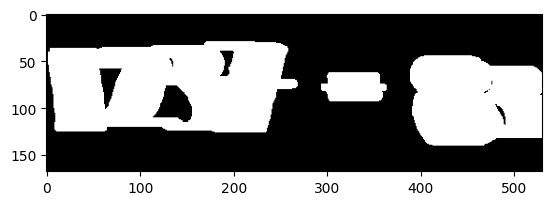

In [642]:
# detecting lines
kernel = np.ones((3,50), np.uint8) # kernel of size 3x85 to detect high intensity of surrounding pixels around selected pixel (blank space)
dilated = cv2.dilate(thresh_img, kernel, iterations = 1)  # finds regions of low intensity & sets all pixels in kernel to low intensity (boxy regions)
plt.imshow(dilated, cmap='gray')

In [643]:
# detects contours
# RETR_EXTERNAL: contour retrieval method (finds outermost contours)
# HAIN_APPROX_NONE: contour approximation method (all points = used for exact shape rather than approximation of shape)
(contours, hierarchy) = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
contour_nums = sorted(contours, key = lambda ctr: cv2.boundingRect(ctr)[0]) # array of contour lines sorted lowest to highest y-value (top->bottom)

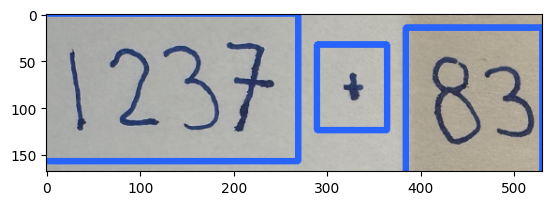

In [644]:
img2 = img.copy()
terms = []

# uses coordinates in contour_lines to draw bounding rectangles
for ctr in contour_nums:
  x, y, w, h = cv2.boundingRect(ctr)
  cv2.rectangle(img2, (x-5, y-30), (x+w, y+h+30), (40, 100, 250), 5) # (image,top-left corner, bottom-right corner, blue, thickness)
  terms.append([x, y-30, x+w, y+h+30])

plt.imshow(img2)

In [645]:
elements = 5
print('Noise:', len(terms)!=elements) # ensuring no overlapping contours/noise

Noise: True


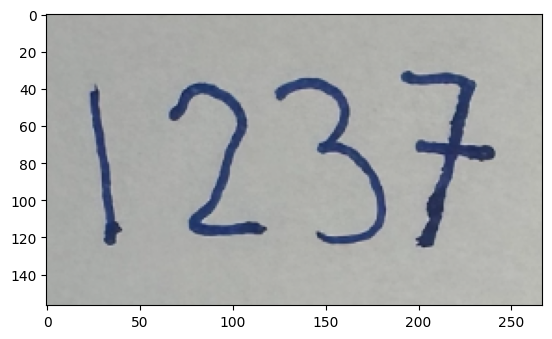

In [646]:
first_term = terms[0]
# [0] = xmin, [1] = ymin, [2] = xmax, [3] = ymax
first_term_roi = img[first_term[1]:first_term[3], first_term[0]:first_term[2]]
img2 = format(first_term_roi)

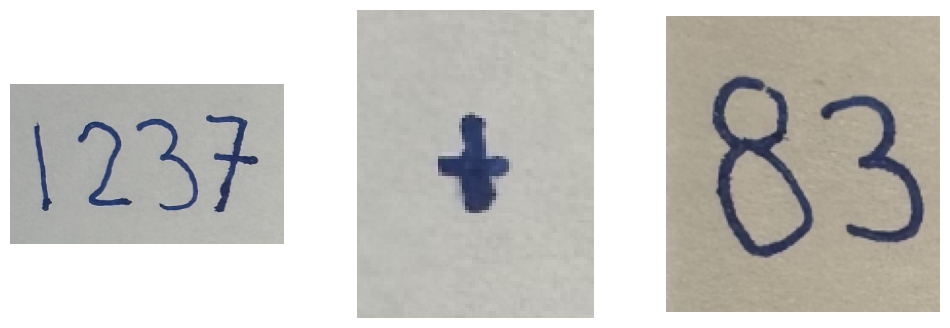

In [647]:
# grid
num_cols = len(terms)
fig, axes = plt.subplots(1, num_cols, figsize=(num_cols * 4, 4))

term_roi = []
for i in range(len(terms)):
    image = img[terms[i][1]:terms[i][3], terms[i][0]:terms[i][2]]
    term_roi.append(image)
    axes[i].imshow(image)
    axes[i].axis('off')

## Segmenting  numbers into digits:

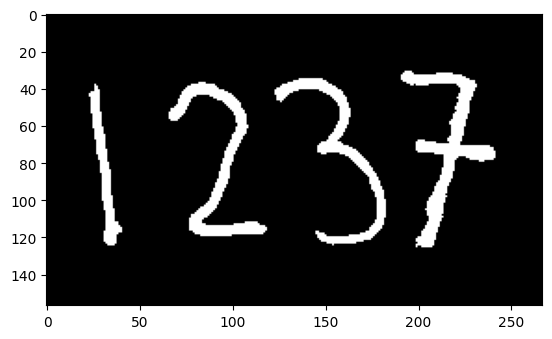

In [648]:
def thresholding_digit(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(img,150,255,cv2.THRESH_BINARY_INV)
    return thresh

term_thresh = []
for i in range(len(term_roi)):
  term_thresh.append(thresholding_digit(term_roi[i]))

plt.imshow(term_thresh[0], cmap='gray')

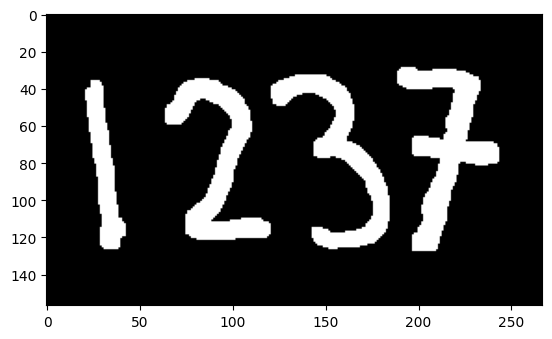

In [649]:
#dilation
kernel = np.ones((5,5), np.uint8)
term_dilated = []
for i in range(len(term_thresh)):
  term_dilated.append(cv2.dilate(term_thresh[i], kernel, iterations = 1))

plt.imshow(term_dilated[0], cmap='gray')

In [651]:
digits = []
outlined_digits = []
unoutlined_digits = []

for i in range(len(term_dilated)):
  image = term_roi[i]
  unoutlined_digits.append(image.copy())
  digs = []
  for num in contour_nums:
    # roi of each line
    x3, y3, w3, h3 = cv2.boundingRect(num)
    roi_dig = term_dilated[i][y3:y3+w3, x3:x3+w3]

    # draw contours on each num
    (cnt2, heirarchy2) = cv2.findContours(roi_dig.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contour_digs = sorted(cnt2, key=lambda cntr : cv2.boundingRect(cntr)[0])

    for contour in contour_digs:

      if cv2.contourArea(contour) < 400:
          continue

      x4, y4, w4, h4 = cv2.boundingRect(contour)
      digs.append([x3+x4, y3+y4, x3+x4+w4, y3+y4+h4])
      cv2.rectangle(image, (x3+x4, y3+y4), (x3+x4+w4, y3+y4+h4), (255,255,100),2)
  outlined_digits.append(image)
  digits.append(digs)

array([[[168, 170, 167],
        [167, 169, 166],
        [168, 170, 167],
        ...,
        [180, 181, 175],
        [183, 184, 177],
        [183, 184, 178]],

       [[166, 169, 166],
        [166, 169, 166],
        [167, 169, 166],
        ...,
        [179, 180, 173],
        [179, 180, 174],
        [182, 183, 176]],

       [[168, 171, 168],
        [167, 169, 166],
        [167, 169, 166],
        ...,
        [178, 179, 173],
        [181, 182, 176],
        [182, 183, 177]],

       ...,

       [[169, 172, 169],
        [167, 170, 167],
        [167, 169, 167],
        ...,
        [187, 188, 182],
        [188, 189, 182],
        [187, 188, 182]],

       [[169, 172, 169],
        [168, 170, 168],
        [168, 171, 168],
        ...,
        [183, 184, 178],
        [185, 186, 180],
        [184, 185, 179]],

       [[170, 172, 169],
        [169, 172, 169],
        [169, 171, 169],
        ...,
        [183, 184, 178],
        [184, 185, 179],
        [184, 185, 179]]], dtype=uint8)
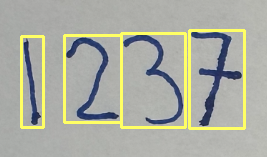

In [652]:
outlined_digits[0]

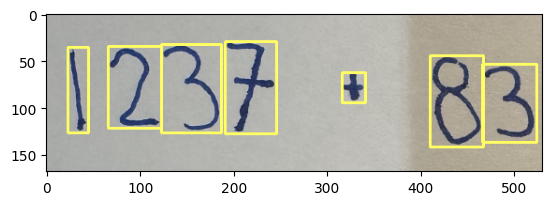

In [653]:
plt.imshow(img)

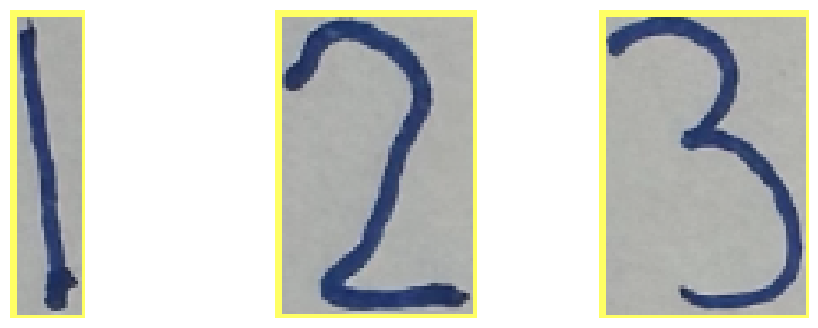

In [654]:
# grid
fig, axes = plt.subplots(1, 3, figsize=(12, 4))  # Change num_cols to 3

for i in range(len(digits[0])-1):
    roi = digits[0][i]
    img_display = unoutlined_digits[0]
    roi_display = img_display[roi[1]:roi[3], roi[0]:roi[2]]
    axes[i].imshow(roi_display)
    axes[i].axis('off')

for j in range(0, len(axes)):
    axes[j].axis('off')

plt.show()

## Digit detection neural network:

In [655]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = tf.keras.utils.normalize(x_train, axis=1)
x_test = tf.keras.utils.normalize(x_test, axis=1)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(28,28))) # input layer
model.add(tf.keras.layers.Dense(128, activation='relu')) # hidden layer
model.add(tf.keras.layers.Dense(128, activation='relu')) # hidden layer
model.add(tf.keras.layers.Dense(10, activation='softmax')) # output layer

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=3)
model.save('handwritten.model')

model = tf.keras.models.load_model('handwritten.model')

loss, accuracy = model.evaluate(x_test, y_test)
print(round(loss,2), round(accuracy,2))

Epoch 1/3
1875/1875 [==============================] - 11s 5ms/step - loss: 0.2628 - accuracy: 0.9225
Epoch 2/3
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1054 - accuracy: 0.9675
Epoch 3/3
313/313 [==============================] - 1s 3ms/step - loss: 0.0871 - accuracy: 0.9714
0.09 0.97


4


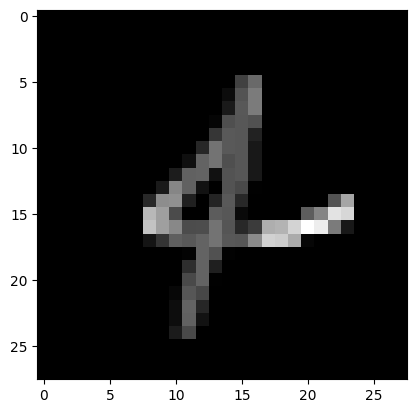

In [656]:
plt.imshow(x_test[300], cmap='gray')
print(y_test[300])

In [674]:
def adjust_img(image):
  # resize, grayscale, contrast, invert
  image = cv2.resize(image, (18, 18)) # 18
  image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

  # testing
  height, width = image.shape

  # Iterate through all pixels and adjust their intensity
  for y in range(height):
      for x in range(width):
          intensity = image[y, x]
          new_intensity = min(255, max(0, intensity * 0.05))
          image[y, x] = new_intensity

  for y in range(height):
      for x in range(width):
          intensity = image[y, x]
          if(intensity>6):
            image[y, x] = 0

  # dilate
  kernel = np.ones((2,2), np.uint8)
  image = cv2.dilate(image, kernel, iterations = 1)

  # background
  background = np.zeros((28, 28), dtype=np.uint8)
  h, w = image.shape
  y_offset = (28 - h) // 2
  x_offset = (28 - w) // 2
  background[y_offset:y_offset+h, x_offset:x_offset+w] = image


  return background

def img_to_int(img):
    img = adjust_img(img)

    # Prediction
    prediction = model.predict(np.array([img]))
    print("Predicted Digit:", np.argmax(prediction))
    return np.argmax(prediction)


1/1 [==============================] - 0s 107ms/step
Predicted Digit: 0


0

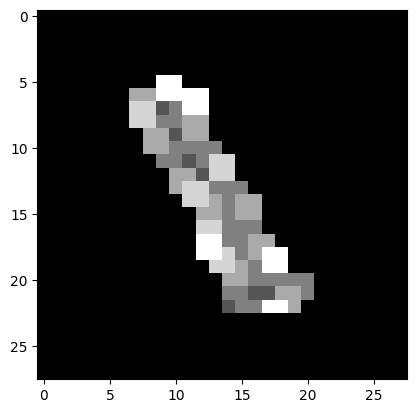

In [681]:
image = unoutlined_digits[0]
roi = digits[0][0]
image = image[roi[1]:roi[3], roi[0]:roi[2]]

image = adjust_img(image)
plt.imshow(image, cmap='gray')

img_to_int(unoutlined_digits[0].copy())

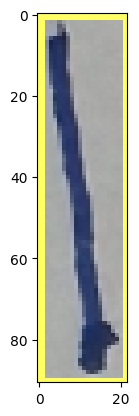

1/1 [==============================] - 0s 20ms/step
Predicted Digit: 8


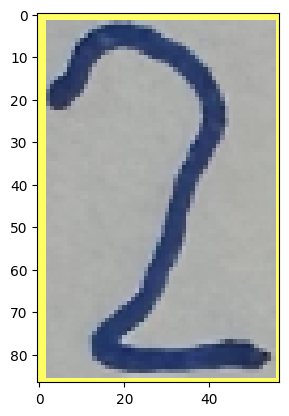

1/1 [==============================] - 0s 21ms/step
Predicted Digit: 2


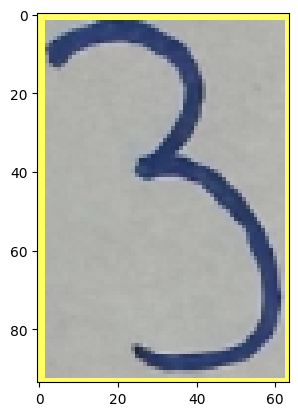

1/1 [==============================] - 0s 23ms/step
Predicted Digit: 3


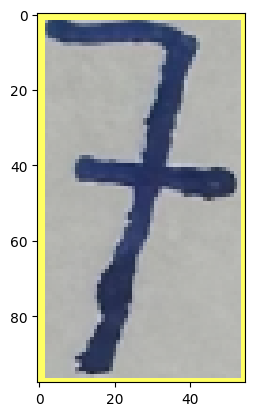

1/1 [==============================] - 0s 24ms/step
Predicted Digit: 7


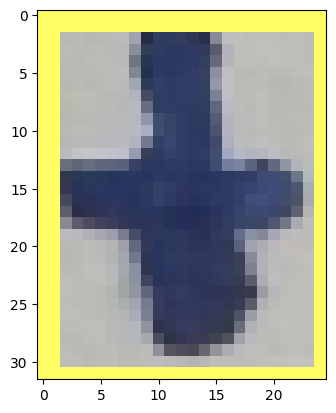

1/1 [==============================] - 0s 23ms/step
Predicted Digit: 6


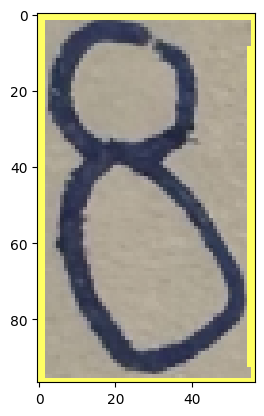

1/1 [==============================] - 0s 22ms/step
Predicted Digit: 8


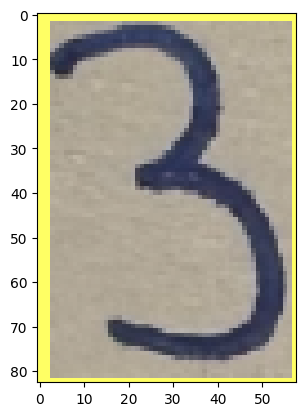

1/1 [==============================] - 0s 26ms/step
Predicted Digit: 3


In [659]:
# answers = [5, 4, 8, 0, 7, 0, 3, 7]

counter = 0
accuracy = 0

term_pred = []
for i in range(len(digits)):
  digit_pred = []
  for j in range(len(digits[i])):
    roi = digits[i][j]
    img_display = unoutlined_digits[i]
    roi_display = img_display[roi[1]:roi[3], roi[0]:roi[2]]
    plt.imshow(roi_display, cmap='gray')
    plt.show()
    ans = img_to_int(roi_display)
    digit_pred.append(ans)

    # if counter != 3 and counter != 5 and ans == answers[counter]:
    #     accuracy+=1
    # counter+=1
  term_pred.append(digit_pred)

# print(round(accuracy /6*100,2))
# print('Accuracy: ', accuracy, '%')

## Transforming Predictions into Equations:

In [660]:
equation = ''
for i in range(len(term_pred)):
  for j in range(len(term_pred[i])):
    if i==1:
      equation += '+'
    elif i == 3:
      equation += '-'
    else:
      equation += str(term_pred[i][j])
  equation += ' '

print(equation)

8237 + 83 
